# **Machine Learning with XGboost in Python**

Welcome to this code-along, where we will use XGBoost to predict booking cancellations with gradient boosting, a powerful machine learning technique! Through this, you'll learn how to create, evaluate, and tune XGBoost models efficiently. There will be time to answer any questions, so please add them!

## **The Dataset**

The session's dataset is a CSV file named `hotel_bookings_clean.csv`, which contains data on hotel bookings. 

### **Acknowledgements**
The dataset was downloaded on [Kaggle](https://www.kaggle.com/jessemostipak/hotel-booking-demand/). The data is originally from an article called [Hotel booking demand datasets](https://www.sciencedirect.com/science/article/pii/S2352340918315191) by Nuno Antonio, Ana de Almeida, and Luis Nunes. It was then cleaned by Thomas Mock and Antoine Bichat for [#TidyTuesday during the week of February 11th, 2020](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md). For the purposes of this code-along, it was further pre-processed to have cleaner ready-to-use features (e.g., dropping irrelevant columns, one-hot-encoding). The dataset has the following [license](https://creativecommons.org/licenses/by/4.0/).

### **Data Dictionary**

It contains the **53 columns**:

_For binary variables: `1` = true and `0` = false._

#### **Target** 
- `is_canceled`: Binary variable indicating whether a booking was canceled

#### **Features** 
- `lead time`: Number of days between booking date and arrival date
- `arrival_date_week_number`, `arrival_date_day_of_month`, `arrival_date_month`: Week number, day date, and month number of arrival date 
- `stays_in_weekend_nights`, `stays_in_week_nights`: Number of weekend nights (Saturday and Sunday) and weeknights (Monday to Friday) the customer booked
- `adults`,`children`,`babies`: Number of adults, children, babies booked for the stay
- `is_repeated_guest`: Binary variable indicating whether the customer was a repeat guest 
- `previous_cancellations`: Number of prior bookings that were canceled by the customer
- `previous_bookings_not_canceled`: Number of prior bookings that were not canceled by the customer
- `required_car_parking_spaces`: Number of parking spaces requested by the customer
- `total_of_special_requests`: Number of special requests made by the customer
- `avg_daily_rate`: Average daily rate, as defined by dividing the sum of all lodging transactions by the total number of staying nights
- `booked_by_company`: Binary variable indicating whether a company booked the booking
- `booked_by_agent`: Binary variable indicating whether an agent booked the booking
- `hotel_City`: Binary variable indicating whether the booked hotel is a "City Hotel"
- `hotel_Resort`: Binary variable indicating whether the booked hotel is a "Resort Hotel"
- `meal_BB`: Binary variable indicating whether a bed & breakfast meal was booked 
- `meal_HB`: Binary variable indicating whether a half board meal was booked
- `meal_FB`: Binary variable indicating whether a full board meal was booked 
- `meal_No_meal`: Binary variable indicating whether there was no meal package booked 
- `market_segment_Aviation`, `market_segment_Complementary`, `market_segment_Corporate`, `market_segment_Direct`, `market_segment_Groups`, `market_segment_Offline_TA_TO`, `market_segment_Online_TA`, `market_segment_Undefined`: Indicates market segment designation with a value of `1`. "TA"= travel agent, "TO"= tour operators
- `distribution_channel_Corporate`, `distribution_channel_Direct`, `distribution_channel_GDS`, `distribution_channel_TA_TO`, `distribution_channel_Undefined`: Indicates booking distribution channel with a value of `1`. "TA"= travel agent, "TO"= tour operators, "GDS" = Global Distribution System
- `reserved_room_type_A`,`reserved_room_type_B`, `reserved_room_type_C`,`reserved_room_type_D`, `reserved_room_type_E`, `reserved_room_type_F`, `reserved_room_type_G`, `reserved_room_type_H`, `reserved_room_type_L`: Indicates code of room type reserved with a value of `1`. Code is presented instead of designation for anonymity reasons
- `deposit_type_No_Deposit`: Binary variable indicating whether a deposit was made
- `deposit_type_Non_Refund`: Binary variable indicating whether a deposit was made in the value of the total stay cost
- `deposit_type_Refundable`: Binary variable indicating whether a deposit was made with a value under the total stay cost 
- `customer_type_Contract`: Binary variable indicating whether the booking has an allotment or other type of contract associated to it 
- `customer_type_Group`: Binary variable indicating whether the booking is associated to a group 
- `customer_type_Transient`: Binary variable indicating whether the booking is not part of a group or contract, and is not associated to other transient booking
- `customer_type_Transient-Party`: Binary variable indicating whether the booking is transient, but is associated to at least another transient booking

---



## **1. Getting to know our data**

Let's get to know our columns and split our data into features and labels!

In [2]:
# Import libraries
import pandas as pd
import xgboost as xgb # XGBoost typically uses the alias "xgb"
import numpy as np

In [3]:
# Read in the dataset
bookings = pd.read_csv('hotel_bookings_clean.csv')

# List out our columns
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119210 entries, 0 to 119209
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119210 non-null  int64  
 1   lead_time                       119210 non-null  int64  
 2   arrival_date_week_number        119210 non-null  int64  
 3   arrival_date_day_of_month       119210 non-null  int64  
 4   arrival_date_month              119210 non-null  int64  
 5   stays_in_weekend_nights         119210 non-null  int64  
 6   stays_in_week_nights            119210 non-null  int64  
 7   adults                          119210 non-null  int64  
 8   children                        119206 non-null  float64
 9   babies                          119210 non-null  int64  
 10  is_repeated_guest               119210 non-null  int64  
 11  previous_cancellations          119210 non-null  int64  
 12  previous_booking

It looks like we have 53 columns with 119,210 rows. All the datatypes are numeric and ready for use.

In [4]:
# Take a closer look at column distributions
bookings.describe()

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_No_Deposit,deposit_type_Non_Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
count,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119206.000000,119210.000000,...,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000
mean,0.370766,104.109227,27.163376,15.798717,6.552051,0.927053,2.499195,1.859206,0.104047,0.007961,...,0.017549,0.005042,0.000050,0.876277,0.122364,0.001359,0.034158,0.004815,0.750575,0.210452
std,0.483012,106.875450,13.601107,8.781070,3.089796,0.995117,1.897106,0.575186,0.398842,0.097509,...,0.131305,0.070825,0.007094,0.329266,0.327707,0.036839,0.181636,0.069223,0.432682,0.407631
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,16.000000,8.000000,4.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,69.000000,28.000000,16.000000,7.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,161.000000,38.000000,23.000000,9.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,737.000000,53.000000,31.000000,12.000000,19.000000,50.000000,55.000000,10.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

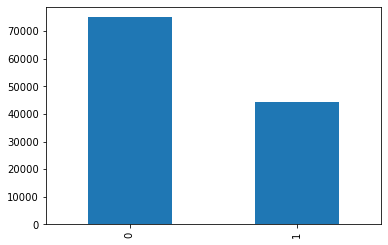

In [5]:
# Plot cancellation counts to visualize proportion of not cancelled and cancelled
bookings['is_canceled'].value_counts().plot(kind="bar")

We see that our data are quite imbalanced. Remember for our binary variables, like `is_canceled`, `1` = true and `0` = false.

In [6]:
# Get an exact percentage of not cancelled and cancelled
bookings['is_canceled'].value_counts()/bookings["is_canceled"].count()

0    0.629234
1    0.370766
Name: is_canceled, dtype: float64

### **Splitting data**
Let's split our label and features so we can get to building models! The first column is our target label `is_canceled`. The rest are features.

In [7]:
# Define X and y
X, y =bookings.iloc[:,1:], bookings.iloc[:,0]

## **2. Your First XGBoost Classifier**

XGBoost has a  [scikit-learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn), which is useful if you want to use different scikit-learn classes and methods on an XGBoost model (e.g.,`predict()`, `fit()`).  In this section, we'll try the API out with the `xgboost.XGBClassifier()` class and get a baseline accuracy for the rest of our work. So that our results are reproducible, we'll set the `random_state=123`.

As a reminder, gradient boosting sequentially trains weak learners where each weak learner tries to correct its predecessor's mistakes. First, we'll instantiate a simple XGBoost classifier without changing any of the other parameters, and we'll inspect its parameters.

In [8]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
# Train and test split using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Instatiate a XGBClassifier 
xgb_clf=xgb.XGBClassifier(random_state=123)

# Inspect the parameters
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 123,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

There's a couple of things to note:
- The `booster` parameter is `gbtree`.  This means the weak learners, or boosters, are decision trees in this model. `gbtree` is the default, and we will keep it this way.
- The `objective` function, or loss function, is defined as `binary:logistic`. The objective function quantifies how far off a prediction is from the actual results. We want to minimize this to have the smallest possible loss. `binary:logistic` is the default for classifiers. `binary:logistic` outputs the actual predicted probability of the positive class (in our case, that a booking is cancelled).
- `n_estimators` is the number of gradient boosted trees we want in our model. It's equivalent to the number of boosting rounds. For our purposes, we don't want too many boosting rounds, or training will take too long.

<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/n_estimators.png?raw=true" width = "70%"> 
</p>

<br>

- `max_depth` is the maximum tree depth allowed. Tree depth is the length of the longest path from the root node to a leaf node. Making this too high will give our model more variance, or more potential to overfit. Similar to `n_estimators`, the more we increase this, the longer our training period will be. 


<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/max_depth.png?raw=true" width = "25%"> 
</p>

- For our `eval_metric` (evaluation metric for validation data), we will use `error` as defined by [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/parameter.html):

> Binary classification error rate. It is calculated as #(wrong cases)/#(all cases). For the predictions, the evaluation will regard the instances with prediction value larger than 0.5 as positive instances, and the others as negative instances.

In [14]:
# We import the appropriate functions as we will make GridSearch
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score,recall_score

# First we define the grid as dictionary
param_grid={'n_estimators':[600],
            'max_depth':[8],
            'learning_rate':[0.3],
            'gamma':[0.01],
            'scale_pos_weight':[1],
            "min_child_weight":[1],
            'colsample_bytree':[1],'max_delta_step':[5]}

# We define our Stratified folds and run the algorithm
xgb_clf=xgb.XGBClassifier(objective="binary:logistic", eval_metric="error",random_state=123,n_estimators=600,max_depth=8,
                          learning_rate=0.3,gamma=0.01,scale_pos_weight=2,colsample_bytree=1,max_delta_step=5,use_label_encoder=False)
xgb_clf.fit(X_train,y_train)
preds=xgb_clf.predict(X_test)
print("The accuracy score is", accuracy_score(y_test,preds))
print("The f1 score is", f1_score(y_test,preds))
print("The precision score is", precision_score(y_test,preds))
print("The recall score is", recall_score(y_test,preds))


The accuracy score is 0.8472163968347175
The f1 score is 0.7964535836686037
The precision score is 0.7842993396918562
The recall score is 0.8089904646586953


In [24]:
preds2=(xgb_clf.predict_proba(X_test)[:,1] >=0.4).astype(int)
print(classification_report(y_test, preds2))
print(confusion_matrix(y_test, preds2))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86     22549
           1       0.75      0.84      0.79     13214

    accuracy                           0.84     35763
   macro avg       0.82      0.84      0.83     35763
weighted avg       0.84      0.84      0.84     35763

[[18794  3755]
 [ 2116 11098]]


We are going to use **accuracy** as our metric for this problem since we only have two classes, and the smallest class takes ~37% of the data. For our problem maybe the hotel would like not to overbook and commit resources that can not be used. So, it seems that <b> False Negative </b> is more important for our case. In our case false negative means to say that the customers will not cancel their reservation while in fact they will cancel it. That's why a threshold of 0.4 was chosen.

### **Creating our confusion matrix**

The confusion matrix above does not say much. It would be better, if we made our confusion matrix more understandable for the reader!

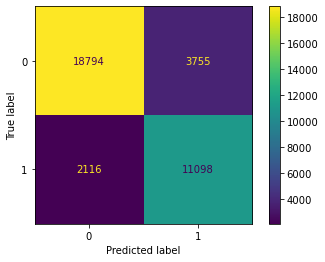

In [28]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(y_test, preds2, labels=xgb_clf.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot()
plt.show()

### **Visualizing the ROC curve**

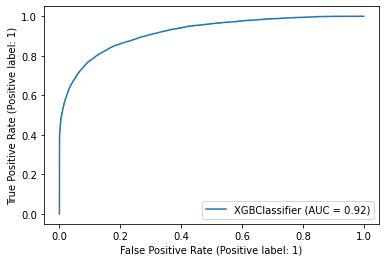

In [30]:
#now lets visualize our roc curve
from sklearn import metrics
metrics.plot_roc_curve(xgb_clf, X_test, y_test)
plt.show()

### **Visualizing your tree**

`XGBoost` has two handy visualization functions for interpreting results.

The first is `plot_importance()`  which plots feature importance, meaning, how predictive each feature is for the target variable. It takes in the fitted XGBoost model.


#### **Plotting feature importance**

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

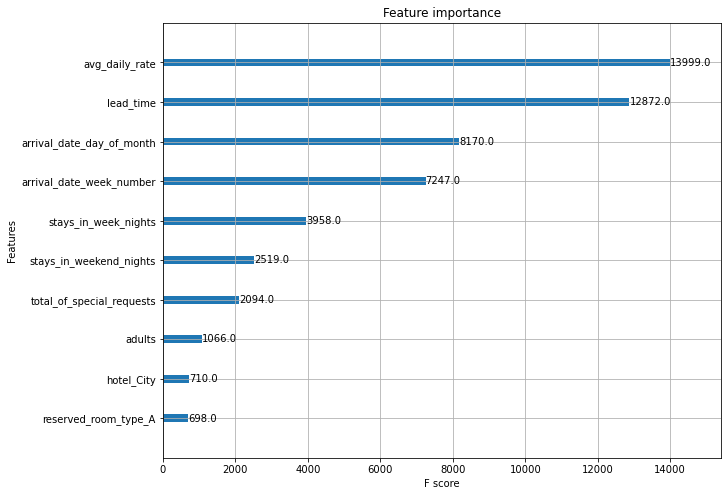

In [56]:
import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance

matplotlib.rcParams['figure.figsize'] = (10.0, 8)

# Plot feature importance
plot_importance(xgb_clf,max_num_features=15)

How is importance calculated? Here's an excerpt from the [documentation](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting):

> **importance_type (str, default "weight") –**
> How the importance is calculated: either “weight”, “gain”, or “cover”
> - ”weight” is the number of times a feature appears in a tree
> - ”gain” is the average gain of splits which use the feature
> - ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

We'll focus on the first two. Gain is a way to quantify how much a feature contributes to improving accuracy. Let's try out `gain` to see how it differs from `weight`.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

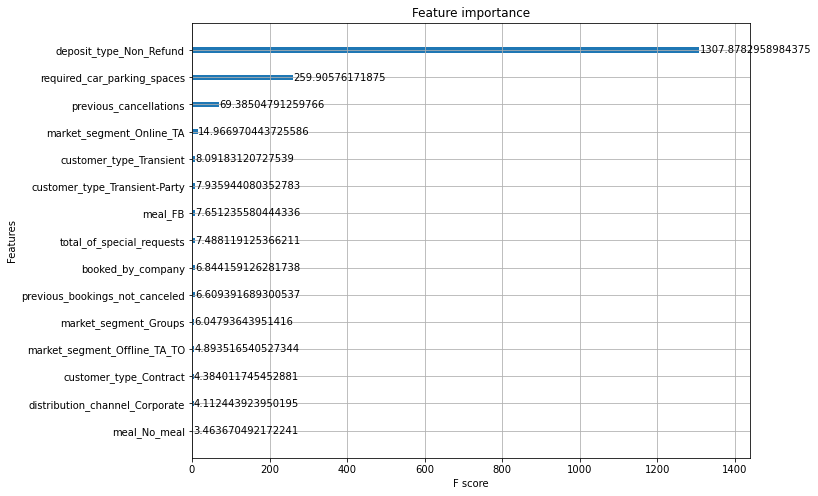

In [57]:
# Plot gain instead of weight
# Plot feature importance
plot_importance(xgb_clf,max_num_features=15,importance_type="gain")

Here we see the ordering of features differs quite a bit between `gain` and `weight`! This implies that (1) feature importance can be subjective, and (2) the number of appearances a feature has on a tree is not necessarily correlated to how much gain it brings. For example, a binary variable has less of a chance to appear as many times as a continuous variable on a tree, since there are only two outputs. However, it can still be a powerful feature.